In [2]:
from skimage import data, feature, color, filters, img_as_float, io
from skimage.transform import rescale
from matplotlib import pyplot as plt
from math import sqrt, pi, exp
import numpy as np
import matrix_derivative as md

Text(0.5,1,'Original Image1')

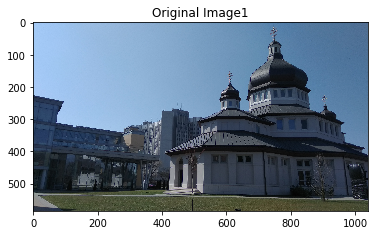

In [13]:
# original_image1 = img_as_float(io.imread("church_1.jpg"))
original_image1 = rescale(img_as_float(io.imread("../../data/input/church_1.jpg")), 1.0 / 4.0, anti_aliasing=False, mode='constant', multichannel='False')
img1 = color.rgb2gray(original_image1)

# original_image2 = img_as_float(io.imread("church_2.jpg"))
original_image2 = rescale(img_as_float(io.imread("../../data/input/shept_1.jpg")), 1.0 / 4.0, anti_aliasing=False, mode='constant', multichannel='False')
img2 = color.rgb2gray(original_image2)


plt.imshow(original_image1)
plt.title('Original Image1')

Text(0.5,1,'Original Image2')

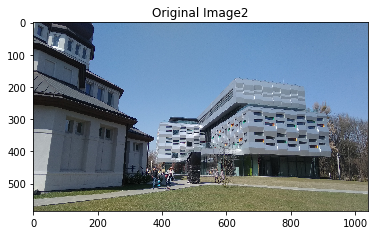

In [14]:
plt.imshow(original_image2)
plt.title('Original Image2')

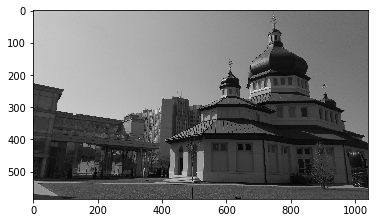

In [15]:
plt.imshow(img1, cmap='gray') # not blured

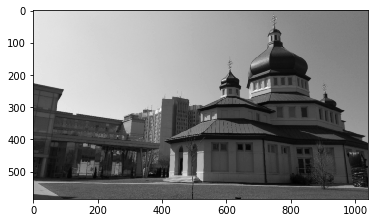

In [16]:
plt.imshow(filters.gaussian(img1, 1), cmap='gray')

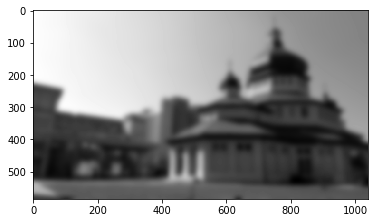

In [17]:
plt.imshow(filters.gaussian(img1, 8), cmap='gray')

Here is a realization of gaussian blur with example of use.
However built-in analog is optimazied and works faster, so it will be used in next steps.

Text(0.5,1,'blured with own function, sigma 4')

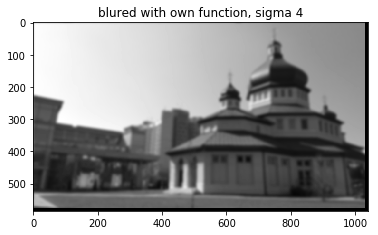

In [18]:
def gaussian_kernel(x, y, sigma):
    return (exp(\
                -((x**2 + y**2)\
                  /(2 * sigma**2))\
               ))\
            /(2 * pi * sigma**2)

def convolution(x0, y0, image, sigma):
    okil = sigma * 2
    res = 0
    for i in range(x0 - okil, x0 + okil + 1):
        for j in range(y0 - okil, y0 + okil + 1):
            try:
                current_pixel = image[i, j]
            except Exception as e:
                return 0
            res += gaussian_kernel(x0 - i, y0 - j, sigma) * current_pixel
    return res

def gaussian_blur(image, sigma):
    height = len(image)
    width = len(image[0])
    blured = np.full((height, width), .0)
    
    for i in range(height):
        for j in range(width):
            blured[i, j] = convolution(i, j, image, sigma)    

    return blured

blured = gaussian_blur(img1, 4)
plt.imshow(blured, cmap='gray')
plt.title('blured with own function, sigma 4')

You can compare the images above and below and persuade, they are very similiar

Text(0.5,1,'blured using built-in function, sigma 4')

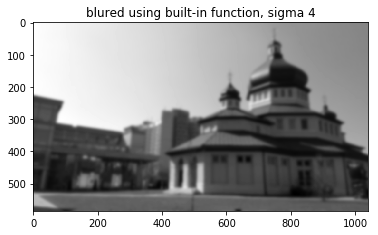

In [19]:
plt.imshow(filters.gaussian(img1, 4), cmap='gray')
plt.title('blured using built-in function, sigma 4')

Set constants needed for finding difference of gaussians

In [20]:
scale_per_octave = 2
k = 2 ** (1 / scale_per_octave)
sigma = 1.6
octaves = 5
images_in_octave = scale_per_octave + 3
low_contrast_threshold = 0.01

The function below blur image using gaussian blur with different sigma and subtrstarct them from each other (for detail info, see docs)

In [21]:
def get_gaussians(image):
    dogs = []
    dogs_ind = 0
    for octave in range(1, octaves):
        print('octave:', octave)
        for _ in range(images_in_octave):
            local_sigma = sigma * scale_per_octave ** (octave - 1) * k ** _
            diff1 = filters.gaussian(image, k * local_sigma)
            diff2 = filters.gaussian(image, local_sigma)

            idx = (octave - 1) * images_in_octave + images_in_octave * (octave - 1) + _ + 1
            plt.subplot((octaves - 1) * 2, images_in_octave, idx)
            plt.imshow(diff1, cmap='gray')
            print('sigma:', local_sigma)

            if _ == images_in_octave - 1:
                continue
            dogs.append(diff1 - diff2)
            plt.subplot((octaves - 1) * 2, images_in_octave, idx + octaves)
            plt.imshow(dogs[dogs_ind], cmap='gray')
            dogs_ind += 1
    return dogs


Function-helpers to values of all neighbors (from current image, from image below and image above) of point.

In [28]:
neighbors2D = lambda dogs, y, x : [ (y2, x2) for x2 in range(x - 1, x + 2)
                               for y2 in range(y - 1, y + 2)
                               if (-1 < x < len(dogs[0][0]) - 1) and
                                   (-1 < y < len(dogs[0]) - 1) and
                                   (0 <= x2 < len(dogs[0][0])) and
                                   (0 <= y2 < len(dogs[0])) ]

neighbors = lambda dogs, d, m, n : \
            [dogs[d - 1][x][y] for x, y in neighbors2D(dogs, m, n)] + \
            [dogs[d][x][y] for x, y in neighbors2D(dogs, m, n)] + \
            [dogs[d + 1][x][y] for x, y in neighbors2D(dogs, m, n)]


Compare point with its 26 neighbors and choose it if it's minimum or maximum - the potential extremum.
Also here is used threshold for its value 0.01. Lowe used 0.03 in his experiments.

In [23]:
def candidat_keypoints(gaussians):
    points = set()
    for d in range(1, len(gaussians) - 1):
        for m in range(1, len(gaussians[0]) - 1):
            for n in range(1, len(gaussians[0][0]) - 1):
                ngh = neighbors(gaussians, d, m, n)
                pixel = gaussians[d][m][n]
                if ngh and (pixel == min(ngh) or pixel == max(ngh)) and pixel > low_contrast_threshold:
                    points.add(tuple([m, n, d]))
    return points

Draw found keypoints as blobs - the size of circle is proportional to sigma (level of bluring) with what it \[keypoint\] was found. The bigger corners are detected with bigger sigma.

In [24]:
def draw_kps(blobs, image):
    ax = plt.subplot()
    
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='white', linewidth=1, fill=False)
        ax.add_patch(c)
    
    plt.imshow(image)
    plt.title('Detected keypoints')
    plt.show()

In [ ]:
g = get_gaussians(img1)

octave: 1
sigma: 1.6
sigma: 2.2627416997969525
sigma: 3.200000000000001
sigma: 4.525483399593905
sigma: 6.400000000000002
octave: 2
sigma: 3.2
sigma: 4.525483399593905
sigma: 6.400000000000002
sigma: 9.05096679918781
sigma: 12.800000000000004
octave: 3
sigma: 6.4
sigma: 9.05096679918781
sigma: 12.800000000000004
sigma: 18.10193359837562
sigma: 25.60000000000001
octave: 4
sigma: 12.8
sigma: 18.10193359837562
sigma: 25.60000000000001
sigma: 36.20386719675124
sigma: 51.20000000000002


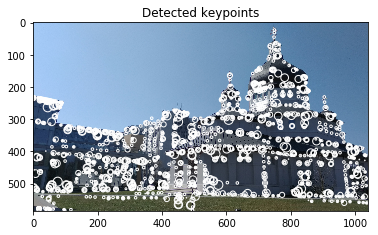

In [46]:
potential_kpts = candidat_keypoints(g)
draw_kps(potential_kpts, original_image1)

octave: 1
sigma: 1.6
sigma: 2.2627416997969525
sigma: 3.200000000000001
sigma: 4.525483399593905
sigma: 6.400000000000002
octave: 2
sigma: 3.2
sigma: 4.525483399593905
sigma: 6.400000000000002
sigma: 9.05096679918781
sigma: 12.800000000000004
octave: 3
sigma: 6.4
sigma: 9.05096679918781
sigma: 12.800000000000004
sigma: 18.10193359837562
sigma: 25.60000000000001
octave: 4
sigma: 12.8
sigma: 18.10193359837562
sigma: 25.60000000000001
sigma: 36.20386719675124
sigma: 51.20000000000002


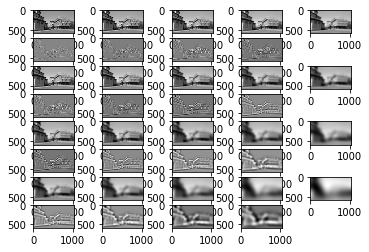

In [25]:
g = get_gaussians(img2)

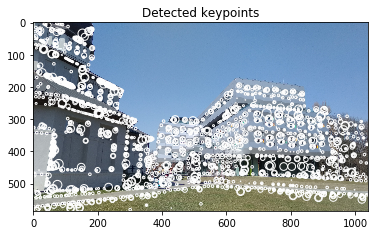

In [29]:
potential_kpts = candidat_keypoints(g)
draw_kps(potential_kpts, original_image2)

Text(0.5,1,'magnitude')

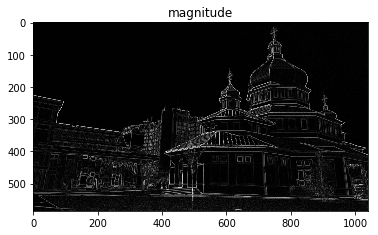

In [45]:
magn = md.magnitude(md.dx(img1), md.dy(img1))
plt.imshow(magn, cmap='gray')
plt.title("magnitude")

Text(0.5,1,'angle')

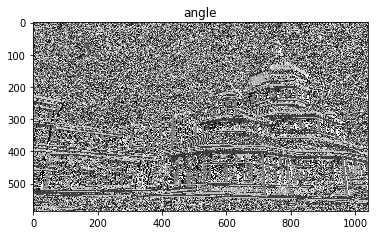

In [6]:
angle = md.angle(md.dx(img1), md.dy(img1))
plt.imshow(angle, cmap='gray')
plt.title("angle")